# todo обновить!

На вход модели подается следующий граф планировки:
каждая комната и наружный контур имеют ребра от каждой точки контура с своим центрам
центры помещений соединенеы между собой ребром, если из одного помещения можно пройти в другое
так же все центры комнат соеденены с центром наружного контура
все центры дверей и окон соеденины с центрами помещений, к которым они принадлежат

все типы объектов (дверь, комната, если да, кто какая) переводятся в ohe и передаются в фичи точек  

На выход подаются упрощенные координаты точек помещений (не более 16, если больше, то контур сокращается по приниципу максимизации сохраненной площади, так же удаляются точки которые не сильно влияют на площадь, т.е. небольшие выступы)

Кроме точек контура из модели выходят веса точек, если вес точки > 0.5 то точка используется, если менее, не считается точкой контура
т.е. поскольку выход координат фиксированной размерности - 16 точек, то некоторые точки нужно удалять.

Лосс состоит из 2-ух частей - геометрический и лосс весов
Геометрический лосс - сравнение расстояний между точками целевого и предсказанного контура. Поскольку заставлять модель вычивать порядок точек не обязательно, сравнивается исходный и все вариатоы смещения пресказанного контура, в лосс попадает минимальная разница 

Весовой лосс - разница между весом и либо 0, либо 1, в зависимости от того что ближе

На данной стадии лосс эксперементов лосс не отражает визуальную приемлимость картинки  

In [1]:
#!pkill -9 -f "planning" 
#1128
#source /home/ubn/Documents/SMC/projects/open_space_planning/.tmp_venv/bin/activate
#tensorboard --logdir "/home/ubn/Documents/SMC/projects/open_space_planning/ds/sw_dw_orig/tensorboard_logs/" --port 8008

In [1]:
# для работы необходима основные библиотеки
# torch_geometric==2.5.0
# networkx==3.2.1
!pip install scikit-learn
!pip install torch_geometric


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import pickle
import random

from IPython.display import clear_output
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential
from torch import Tensor, nn

!pip install torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    EdgeConv,
    GATConv,
    GATv2Conv,
    GCNConv,
    GravNetConv,
    Linear,
    MessagePassing,
    Sequential,
    XConv,
    global_max_pool,
)
from torch_geometric.nn.pool import max_pool
import time


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'torch_geometric'

In [4]:
def pklsave(v, n):
    """
        Сохраниение сериализуемых данных в формате pickle на диск 
        args:
            v - данные для сохранения,
            n - путь к файлу 
        returns:
            None

    """
    with open(n, 'wb') as f:
        pickle.dump(v, f)


def pkload(n):
    """
        Загрузка сериализуемых данных формате pickle с диска
        args:
            n - путь к файлу
        returns:
            сериализованные данные
    """
    with open(n, 'rb') as f:
        return pickle.load(f)

In [5]:
# Типы подтипы помещений
NODE_TYPES = ['DOOR_center',
         'DOOR_end',
         'DOOR_start',
         'ENTRANCE_DOOR_center',
         'ENTRANCE_DOOR_end',
         'ENTRANCE_DOOR_start',
         'WINDOW_center',
         'WINDOW_end',
         'WINDOW_start',
         'apart_center',
         'outer_point',
         'area_center',
         'targ_node',]
NODE_SUBTYPES = ['',
            'KITCHEN',
            'PATIO',
            'ELEVATOR',
            'BEDROOM',
            'TERRACE',
            'VOID',
            'STOREROOM',
            'DINING',
            'BATHROOM',
            'GARDEN',
            'KITCHEN_DINING',
            'WINTERGARTEN',
            'ROOM',
            'STAIRCASE',
            'STUDIO',
            'CORRIDOR',
            'LIGHTWELL',
            'OUTDOOR_VOID',
            'LIVING_ROOM']

EDGE_TYPES = ['',
              'line',
              'logic',
              'connection_passage',
              'connection_door',
              'targ_node_edge_0',
              'targ_node_edge_1',
              'targ_node_edge_2',
              'btw_targ_node_edge',]

TOTAL_CLASSES = len(NODE_TYPES) - 1 + len(NODE_SUBTYPES)


# максимальное количество точек контура
MAX_POINTS = 16
# эмпирический парамтр кривизны
MIN_CURV = 0.2


In [6]:

# переменные обучения
CUDA_0 = torch.device('cuda:0')
CUDA_A = torch.device('cpu')
#CUDA_0 = torch.device('cpu')
CPU_0 = torch.device('cpu')

In [7]:
CPU_0 = torch.device('cpu')

In [8]:
# загрузка данных с диска
Graph = pkload('/home/ubn/Documents/SMC/projects/open_space_planning/ds/sw_dw_orig/graphs_w_bounds_list.pkl')

In [9]:
# разделение данных на обучающию и валидационную выборки
Graph_train, Graph_val = train_test_split(
    Graph, test_size=0.33, random_state=42)

In [10]:
def close_cont(cont):
    """
        Добавление первой точки в конец контура для массива numpy
        args:
            cont:nunmpy.array : размер Nx2
        returns:
            nunmpy.array
    """
    return np.concatenate((cont, cont[0:1]), axis=0)


def close_cont_trch(cont):
    """
        Добавление первой точки в конец контура для тензоров
        args:
            cont:torch.tensor : размер Nx2
        returns:
            torch.tensor
    """
    return torch.cat((cont, cont[0:1]), dim=0)

In [11]:
def get_inds_from_gr(graph, string_list=[], keys_list=[]):
    """
    Получение всех ребер, в свойствах которых есть любая из указанных строк
    Args:
        gr - граф
        string_list - список строк, по котоым ищется ребро
    returns:
        тензор индексов ребер размером 2xN
    """

    edge_index = []
    for n0, n1, d in graph.edges(data=True):
        if d.get("type", "") in string_list or any([k in d.keys() for k in keys_list]):
            edge_index.append([n0, n1])
    edge_index = list(zip(*edge_index))

    return torch.tensor(edge_index, dtype=torch.long, device=CUDA_A)


def get_inds_of_nodes(graph, string_list):
    """
    Получение всех вершин, в свойствах которых есть любая из указанных строк
    Args:
        gr - граф
        string_list - список строк, по котоым ищется вершина
    returns:
        тензор индексов вершин размером N
    """

    nodes_indices = []
    for n, d in graph.nodes(data=True):
        if d["type"] in string_list:
            nodes_indices.append(n)

    return nodes_indices


def rev_edges(edge_index):
    """
    реверс направлений ребер
    args:
        edge_index:torch.tensor - массив индексов 2хN
    returns:
        массив индексов 2хN
    """
    return torch.cat([edge_index[1].unsqueeze(0), edge_index[0].unsqueeze(0)], 0)


def add_reverse_dir(edge_index):
    """
    добавлние обратного направления ребер
    args:
        edge_index:torch.tensor - массив индексов 2хN
    returns:
        массив индексов 2х(N*2)
    """
    rev = rev_edges(edge_index)
    edge_index = torch.cat((edge_index, rev), 1)
    return edge_index


def add_self_loop_dir(edge_index):
    """
    добавление self-loop ребер
    args:
        edge_index:torch.tensor - массив индексов 2хN
    returns:
        массив индексов 2х(N*2)
    """
    slf = edge_index[1][None, :].repeat(2, 1)
    edge_index = torch.cat((edge_index, slf), 1)
    return edge_index

In [12]:

NUMBER_OF_BORDER_POINTS_DATASET = 11
NUMBER_OF_BORDER_POINTS = 3
import itertools

absl-py==2.1.0
aiohttp==3.9.3
aiosignal==1.3.1
anyio==4.3.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
autopep8==2.1.0
Babel==2.14.0
beautifulsoup4==4.12.3
black==24.3.0
bleach==6.1.0
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
clearml==1.15.1
click==8.1.7
comm==0.2.1
contourpy==1.2.0
cycler==0.12.1
Cython==3.0.8
debugpy==1.8.1
decorator==4.4.2
defusedxml==0.7.1
euclid3==0.1
exceptiongroup==1.2.0
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.1
fonttools==4.49.0
fqdn==1.5.1
frozenlist==1.4.1
fsspec==2024.2.0
furl==2.1.3
grpcio==1.62.1
h11==0.14.0
httpcore==1.0.4
httpx==0.27.0
idna==3.6
ipykernel==6.29.2
ipympl==0.9.3
ipynbname==2023.2.0.0
ipython==8.22.1
ipython-genutils==0.2.0
ipywidgets==8.1.2
isoduration==20.11.0
isort==5.13.2
jedi==0.19.1
Jinja2==3.1.3
joblib==1.3.2
json5==0.9.17
jsonpointer==2.4
jsonschema==4.21.1
jsonschema-specifications==2023.12.1
jupyter==1.0.0
jupyter-

In [13]:
def ttf(data):
    """
        проеобразование в тензор float32
        args:
            data:List | numpy.array | torch.tensor - данные для преобразования
        returns:
            тензор torch.float32
    """
    return torch.tensor(data, dtype=torch.float32, device=CUDA_A)


def opposite_node(nodes, node):
    """
        возвращает противоположный от данного узла узел в ребре
    """
    return list(set(nodes) - set([node]))[0]


def ttl(data):
    """
        проеобразование в тензор long
        args:
            data:List | numpy.array | torch.tensor - данные для преобразования
        returns:
            тензор torch.long
    """
    return torch.tensor(data, dtype=torch.long, device=CUDA_A)


def get_curv_area(countour):
    """
        Получение кривизны точек
        args:
            numpy - контур
        returns:
            массив - площадь параллепипеда образованного входящей и исходящей линиями, 
            массив - площадь параллепипеда образованного входящей линией повернутой на 90 градусов и исходящей линиями
    """
    # круговое смещение точек контура
    countour_rolled = np.roll(countour, -1, 0)

    # подсчет векторов
    vects = countour_rolled - countour

    # круговое смещение векторов
    vects_prev = np.roll(vects, 1, 0)

    # поворот смещенных векторов на 90 градусов
    vects_prev_ort = np.roll(vects_prev, shift=(0, 1), axis=(0, 1))
    vects_prev_ort[:, 1] = - vects_prev_ort[:, 1]

    return np.abs(np.cross(vects_prev, vects)), np.abs((vects_prev_ort * vects).sum(1))


def augment_graph(graph):
    graph = nx.DiGraph(graph)
    # first_label is the starting integer label, in this case zero
    edges_to_remove = []
    nodes_to_remove = set()
    for i, j, egde_data in graph.edges(data=True):
        if graph.nodes[i].get('type', '') == "DOOR_center" or \
            graph.nodes[i].get('type', '') == "DOOR_start" or \
                graph.nodes[i].get('type', '') == "DOOR_end":
            edges_to_remove.append((i, j))
            nodes_to_remove.add(i)

    for e in edges_to_remove:
        graph.remove_edge(*e)

    for n in nodes_to_remove:
        graph.remove_node(n)

    graph = nx.relabel.convert_node_labels_to_integers(
        graph, first_label=0, ordering='default'
    )
    graph = nx.DiGraph(graph)
    # количество узлов
    current_node = graph.number_of_nodes()

    # в сэмпл входит только один граф планировки

    # аугментация графа

    area_center_indices = get_inds_of_nodes(graph, "area_center")
    links_btw_all_areas = itertools.combinations(area_center_indices, r=2)

    for i, j in links_btw_all_areas:
        graph.add_edge(i, j, **{
            'possible_border': True,
            # 'targ_node_edge_index': 0
        })
        graph.add_edge(j, i, **{
            'possible_border': True,
            # 'targ_node_edge_index': 0
        })
        graph.add_node(current_node, **{
            'pos': np.array([0.0, 0.0]),
            'in_walls_doors': np.zeros((2)),
            'type': 'targ_node'
        })
        graph.add_edge(i, current_node, **{
            #'targ_node_edge': True,
            'type': f'targ_node_edge_{0}',
            # 'targ_node_edge_index': 0
        })
        graph.add_edge(j, current_node, **{
            #'targ_node_edge': True,
            'type': f'targ_node_edge_{NUMBER_OF_BORDER_POINTS-1}',
            # 'targ_node_edge_index': NUMBER_OF_BORDER_POINTS-1
        })
        prev_node = current_node
        current_node = current_node + 1

        for p in range(1, NUMBER_OF_BORDER_POINTS):
            graph.add_node(current_node, **{
                'pos': np.array([0.0, 0.0]),
                'in_walls_doors': np.zeros((2)),
                'type': 'targ_node'
            })

            graph.add_edge(i, current_node, **{
                #'targ_node_edge': True,
                'type': f'targ_node_edge_{p}',
                # 'targ_node_edge_index': p
            })
            graph.add_edge(j, current_node, **{
                #'targ_node_edge': True,
                'type': f'targ_node_edge_{NUMBER_OF_BORDER_POINTS-1-p}',
                # 'targ_node_edge_index': NUMBER_OF_BORDER_POINTS-1-p
            })

            graph.add_edge(current_node, prev_node, **{
                'targ_node_edge': True,
                'type': 'btw_targ_node_edge'
            })
            #
            graph.add_edge(prev_node, current_node, **{
                'targ_node_edge': True,
                'type': 'btw_targ_node_edge'
            })

            prev_node = current_node

            current_node = current_node + 1

        data = graph.get_edge_data(i, j)
        if not data.get('border', None) is None:
            for e, r in enumerate(range(0, NUMBER_OF_BORDER_POINTS_DATASET, 5)):
                ind = current_node - NUMBER_OF_BORDER_POINTS + e

                graph.nodes[ind].update({
                    'target_pos': data.get('border')[r],
                    'in_walls_doors': [
                        data.get('in_walls')[r],
                        data.get('in_doors')[r]
                    ],
                    'exists': [1]
                })

    # задание индексов OHE
    for n, d in graph.nodes(data=True):
        ind = NODE_TYPES.index(d['type']) + \
            NODE_SUBTYPES.index(d.get('subtype', ''))
        d = {'ohe_index': ind, 'pos': d['pos']}
    return graph


tmp_cache_dict = {}


LEN_EDGE_FEATS = 1 + 1 + 1 + len(EDGE_TYPES)

ANGLE_BINS = 180

def calc_align_vect(vects):
    """
        Расчет наиболее частого угла
        args:
            vects - вектора
        returns:
            
    """
    

    bins_vects = np.zeros((ANGLE_BINS,2))
    for vec in vects:
        ang = np.arctan2(*vec)/np.pi*180
        if ang<0:
            ang = ang + 180

        ang_ind = int(ang/360*ANGLE_BINS)
        #bins_counts[ang_ind]+=np.linalg.norm(vec)
        if np.linalg.norm(bins_vects[ang_ind] + vec) > np.linalg.norm(bins_vects[ang_ind]):
            bins_vects[ang_ind] = bins_vects[ang_ind] + vec
        else:
            bins_vects[ang_ind] = bins_vects[ang_ind] - vec
    bins_vects_length = np.linalg.norm(bins_vects,axis = 1)
    max_ind = bins_vects_length.argmax()
    align_vect = bins_vects[max_ind]
    align_vect = align_vect/np.linalg.norm(align_vect)
    return align_vect

def graph_to_data(graph):

    def create_edge_feats_tensor(graph, edges_index_tensor):
        edges_feats = all_edges_feats = torch.zeros(
            (edges_index_tensor.shape[1], LEN_EDGE_FEATS), dtype=torch.float32, device=CUDA_A)
        for ind in range(edges_index_tensor.shape[1]):
            i = int(edges_index_tensor[0, ind])
            j = int(edges_index_tensor[1, ind])
            edge_data = graph[i][j]
            edge_feats = get_edge_feats(graph, i, j, edge_data)

            edges_feats[ind] = edge_feats
        return edges_feats

    def get_edge_feats(graph, i, j, edge_data):
        edge_feats = torch.zeros(
            (LEN_EDGE_FEATS), dtype=torch.float32, device=CUDA_A)

        data = edge_data

        length = 0.0

        if data.get('type', '') in [
            'line',
            'logic',
            'connection_passage',
            'connection_door'
        ] or not data.get('border', None) is None:
            pos_i = graph.nodes[i].get('pos')
            pos_j = graph.nodes[j].get('pos')
            length = np.linalg.norm(pos_i-pos_j)
        edge_feats[0] = length


        if 'border' in data.keys():
            edge_feats[1] = 1.0

        if 'possible_border' in data.keys():
            edge_feats[2] = 1.0

        ohe_ind = EDGE_TYPES.index(data.get('type', ''))
        edge_feats[3+ohe_ind] = 1.0
        
        return edge_feats

    nodes_count = graph.number_of_nodes()
    # area_centers = get_inds_of_nodes(graph, ["area_center"])
    # apart_center = get_inds_of_nodes(graph, ["apart_center"])[0]
    # edge_index_aprt_cnt_to_areas = ttl(
    #    [[apart_center] * len(area_centers), area_centers])

    # edge_index_targ_all_btw_areas = get_inds_from_gr(
    #    graph, [], keys_list=['possible_border'])

    edge_index_targ_node_edge_0 = get_inds_from_gr(graph, ['targ_node_edge_0'])
    edge_index_targ_node_edge_1 = get_inds_from_gr(graph, ['targ_node_edge_1'])
    edge_index_targ_node_edge_2 = get_inds_from_gr(graph, ['targ_node_edge_2'])

    edge_index_first_graph = torch.tensor(
        list(zip(*[
            (u, v) for u, v in list(graph.edges) if not 'targ_node_edge' in graph[u][v].keys()
        ])),
        dtype=torch.long, device=CUDA_A
    )

    # length
    # x_proj
    # y_proj
    # ['line','logic','connection_passage','connection_door']
    # border
    # possible_border

    edge_feats_first_graph = create_edge_feats_tensor(graph, edge_index_first_graph)

    # получение ребер наружного контура (массив 2xN - индексы начальных и конечных узлов)
    edge_index_line = add_reverse_dir(get_inds_from_gr(graph, ['line']))

    vects = []
    for i in range(edge_index_line.shape[1]):
        i_pos = graph.nodes[int(edge_index_line[0,i])].get('pos')
        j_pos = graph.nodes[int(edge_index_line[1,i])].get('pos')
        vects.append(j_pos-i_pos)
    vects = np.array(vects)

    align_vect = torch.tensor(calc_align_vect(vects))
    # получение ребер между центром квартиры и наружнымконтуром
    edge_index_from_line_to_cnt = get_inds_from_gr(graph, ['logic'])
    # ребра между центром кавртиры и центрами комнат

    # ребра перемещения человека между комнатами
    area_center_indices = get_inds_of_nodes(graph, "apart_center")
    edge_index_all_nodes = torch.arange(
        nodes_count, dtype=torch.long, device=CUDA_A)
    edge_index_from_center_to_all_nodes = torch.cat(
        (ttl(area_center_indices[0:1]).repeat((1, edge_index_all_nodes.shape[0])), edge_index_all_nodes[None, :]), dim=0)

    x = torch.zeros((nodes_count, TOTAL_CLASSES),
                    dtype=torch.float32, device=CUDA_A)
    # edge_index_all_nodes = torch.arange(
    #    nodes_count, dtype=torch.long, device=CUDA_A)

    pos = torch.zeros((nodes_count, 2), dtype=torch.float, device=CUDA_A)
    feats_targ = torch.zeros(
        (nodes_count, 6), dtype=torch.float, device=CUDA_A)

    # сбор нанных со всех узлов, задание ohe исходного массива фичей точек
    for i in range(nodes_count):
        data = graph.nodes[i]
        ind = data.get('ohe_index', -1)
        x[i, ind] = 1.0
        pt = ttf(data.get('pos'))
        pos[i, 0] = pt[0]
        pos[i, 1] = pt[1]
        feats_targ[i, :] = ttf(list(data.get('target_pos', [0.0, 0.0])) + list(
            data.get('in_walls_doors', [0.0, 0.0])) + data.get('exists', [0.0]) + [(data.get('type', "") == 'targ_node') * 1])

    edge_index_debug_btw_targ_node_edge = get_inds_from_gr(
        graph, ['btw_targ_node_edge'])
    # индекс графа для последующей проверки

    


    return (align_vect,
        edge_index_from_center_to_all_nodes,
            edge_index_first_graph,
            edge_feats_first_graph,
            edge_index_targ_node_edge_0,
            edge_index_targ_node_edge_1,
            edge_index_targ_node_edge_2,
            edge_index_line,
            edge_index_from_line_to_cnt,
            x,
            pos,
            feats_targ,
            edge_index_debug_btw_targ_node_edge,
            )


def graphs_to_data(graphs):
    sample_data = []
    prev_time = 0

    for i, graph in enumerate(graphs):
        if time.time() - prev_time > 5:
            clear_output(wait=True)
            print(i,len(graphs))
            prev_time = time.time()
        # создание направленного графа
        graph = augment_graph(graph)

        sample_data.append(graph_to_data(graph))

    return sample_data


In [14]:

if os.path.isfile('train_data_v01.pkl'):
    train_data = pkload('train_data_v01.pkl')
else:
    train_data = graphs_to_data(Graph_train)
    pklsave(train_data,'train_data_v01.pkl')



In [15]:
if os.path.isfile('val_data_v01.pkl'):
    val_data = pkload('val_data_v01.pkl')
else:
    val_data = graphs_to_data(Graph_val)
    pklsave(val_data,'val_data_v01.pkl')

In [16]:


class DataGen():
    def __init__(self, data_):
        """
            Инициализация генератора
            args:
                self - экземпляр класса
                graphs - графы
            returns:
                None
        """
        # self.graphs = graphs
        self.data_ = data_
        self.len_graphs = len(self.data_)

    def __len__(self):
        return self.len_graphs

    def __getitem__(self, key):
        """
            Генерация одного сэмпла обучения
            args:
                self - экземпляр класса,
                key:int - порядковый номер сэмпла
            returns:
                экземпляр класса Data (данные одного сэмпла)
        """
        key = key % self.len_graphs

        # выбор графа по ключу
        data = self.data_[key]

        data = [i.clone().to(CUDA_A) for i in data]

        (align_vect,
        edge_index_from_center_to_all_nodes,
            edge_index_first_graph,
            edge_feats_first_graph,
            edge_index_targ_node_edge_0,
            edge_index_targ_node_edge_1,
            edge_index_targ_node_edge_2,
            edge_index_line,
            edge_index_from_line_to_cnt,
            x,
            pos,
            feats_targ,
            edge_index_debug_btw_targ_node_edge,
         ) = data

        debug_sg_ind = ttl([key]).repeat((x.shape[0]))
        #align_vect[1],align_vect[0] = -align_vect[0],align_vect[1]
        alf = -np.arctan2(float(align_vect[0]),float(align_vect[1])) + int(np.random.rand()*4) * np.pi * 0.5

        #flip_hor = int(np.random.rand()*2)
        #flip_vert = int(np.random.rand()*2)

        rot_matr = ttf([[np.cos(alf), -np.sin(alf)],
                       [np.sin(alf), np.cos(alf),]])

        align_vect = ttf(align_vect)


        pos = torch.matmul(pos[:, None, :].clone(), rot_matr)[:, 0, :]
        #if flip_hor == 1:
        #    pos[:,0] = - pos[:,0]
#
        #if flip_vert == 1:
        #    pos[:,1] = - pos[:,1]
#
        #flip_targ_edges = (flip_vert + flip_hor) % 2 == 1

        targ_pos = feats_targ[:, :2].clone()
        targ_pos = torch.matmul(targ_pos[:, None, :], rot_matr)[:, 0, :]

        #if flip_hor == 1:
        #    targ_pos[:,0] = - targ_pos[:,0]
#
        #if flip_vert == 1:
        #    targ_pos[:,1] = - targ_pos[:,1]

        feats_targ[:, :2] = targ_pos

        rev_rot_matr = rot_matr.clone()
        rev_rot_matr[0, 1] = - rev_rot_matr[0, 1]
        rev_rot_matr[1, 0] = - rev_rot_matr[1, 0]
        rev_rot_matr = rev_rot_matr[None, :]
        rev_rot_matr = rev_rot_matr.repeat((x.shape[0], 1, 1))

        data = Data(edge_index_from_center_to_all_nodes=edge_index_from_center_to_all_nodes,
            edge_index_first_graph=edge_index_first_graph,
            edge_feats_first_graph=edge_feats_first_graph,
            edge_index_targ_node_edge_0=edge_index_targ_node_edge_0,
            edge_index_targ_node_edge_1=edge_index_targ_node_edge_1,
            edge_index_targ_node_edge_2=edge_index_targ_node_edge_2,
            edge_index_line=edge_index_line,
            edge_index_from_line_to_cnt=edge_index_from_line_to_cnt,
            x=x,
            pos=pos,
            feats_targ=feats_targ,
            edge_index_debug_btw_targ_node_edge=edge_index_debug_btw_targ_node_edge,
            debug_sg_ind=debug_sg_ind,
            debug_rev_rot_matr=rev_rot_matr,
            edge_index_debug_all_node_indices=torch.arange((x.shape[0]), dtype=torch.long, device=CUDA_A),
        )

        return data




In [17]:
1 % 2

1

In [18]:
Graph[0].nodes[2]

{'type': 'outer_point', 'pos': array([-5.06972683, -3.64619632])}

In [19]:
import numpy as np
NUMPY_RANDOM = np.random.default_rng()

class LateInitColorPalette:
    """
        Класс создающий ссылки на цвета, количество которых заранее неизвестно
    """

    def __init__(self):
        self.colors_list = []

    def create_color(self):
        """
            Создание словаря, который будет содержать цвет, добавление в список и возвращение ссылки на него
        """
        dict_object = {}
        self.colors_list.append(dict_object)
        return dict_object

    def init_colors(self):
        """
            Вычисление цветов
        """
        cmap = plt.cm.gist_rainbow
        # создание равномерно расспределенной цветовой палитры
        norm = colors.Normalize(vmin=0.0, vmax=float(len(self.colors_list)))
        # создание списка цветов rgb в диапазоне 0.0-1.0
        colors_list_rgb_0_1 = [
            cmap(norm(float(e))) for e in range(len(self.colors_list))
        ]
        for i in range(len(self.colors_list)):
            self.colors_list[i].update({"rgb_1": colors_list_rgb_0_1[i]})


def convert_to_readable(value):
    """
        Замена длинных значений (списков, массивов) на знаки
        args:
            value - любой объект
        returns:
            если не содердит много информации, то value,
            иначе знаки "<>"
    """
    replacement_str = "<>"
    if type(value) == float:
        value = replacement_str
    if type(value) == list:
        if len(value) > 5:
            value = replacement_str
    if type(value) == np.ndarray:
        value = replacement_str

    return value

import mpld3
def plot_sg(g,add_border = True):
    """
        Отрисовка графа.
        Кроме исходного графа к нему добавляются узлы и ребра границ между помещениями
        хранящиется в свойствах некоторых ребер
        args:
            d:nx.DiGraph - граф для отображения
        returns:
            None
    """
    g = nx.DiGraph(g)
    colors_palette = LateInitColorPalette()
    prop_color_dict = {}
    plt.figure(1, figsize=(16, 14), dpi=650)
    edges_color = {}

    bounds = []
    visible_edges_attrs = {}
    visible_edges_attrs_0 = {}
    visible_edges_attrs_1 = {}
    # оюъединение свойств граней со свойствами исходного узла ребра,
    # записываются в свойство ребра

    # итерация по граням
    nodes_to_hide = set()
    edges_to_hide = []
    for u, v, a in g.edges(data=True):
        to_remove = False
        if g.nodes[u].get('type','') == 'targ_node':
            if g.nodes[u].get('targ_pos') is None:
                to_remove = True
                nodes_to_hide.add(u)
        if g.nodes[v].get('type','') == 'targ_node':
            if g.nodes[v].get('targ_pos') is None:
                to_remove = True
                edges_to_hide.append((u,v))
                nodes_to_hide.add(v)
        if not to_remove:
            edge_attr = {}
            edge_attr.update(a)
            
            # свойства исходного узла
            for k, vl in g.nodes[u].items():
                vl = convert_to_readable(vl)
                edge_attr.update({k + "#": vl})

            # свойства грани
            for k, vl in a.items():
                edge_attr[k] = convert_to_readable(vl)

                # отдельная запсиь в спислк границ
                if add_border:
                    if k == "border":
                        bounds.append(vl)


            
            # добавление в отображаемые свойства
            
            visible_edges_attrs.update({(u, v): edge_attr})

            # назначение ссылки на цвет
            prop_color_dict[str(visible_edges_attrs[(u, v)])] = prop_color_dict.get(
                str(visible_edges_attrs[(u, v)]), None
            )
            if prop_color_dict[str(visible_edges_attrs[(u, v)])] is None:
                prop_color_dict[str(visible_edges_attrs[(u, v)])] = (
                    colors_palette.create_color()
                )
            edge_attr.update({"color": prop_color_dict[str(visible_edges_attrs[(u, v)])]})
            if u<v:
                visible_edges_attrs_0[(u, v)] = visible_edges_attrs[(u, v)]
            else:
                visible_edges_attrs_1[(u, v)] = visible_edges_attrs[(u, v)]
    for r in edges_to_hide:
        g.remove_edge(*r)
    for r in nodes_to_hide:
        g.remove_node(r)
    # добавление узлов и ребер границ
    for b in bounds:
        for i in range(1, b.shape[0]):

            prev_node = str(b[i - 1].tolist())
            cur_node = str(b[i].tolist())

            g.add_node(prev_node, **{"pos": b[i - 1]})
            g.add_node(cur_node, **{"pos": b[i]})
            g.add_edge(prev_node, cur_node)

    # задание позиций со случайным смещением, для визуализации совпадающих узлов
    pos = {
        node_name: np.array(node_pos) + (NUMPY_RANDOM.random(2) - 0.5) * 0.01
        for node_name, node_pos in nx.get_node_attributes(g, "pos").items()
    }
    pos2 = {
        node_name: np.array(node_pos) + np.array([0.01,0.01])
        for node_name, node_pos in pos.items()
    }
    for n in pos.keys():
        pos[n] = pos[n] + g.nodes[n].get("target_pos",np.array([0.0,0.0]))
        

    # запись меток узлов
    labels = {}
    for n, d in g.nodes(data=True):
        labels[n] = f"{n}:"
        for k, v in d.items():
            v = convert_to_readable(v)
            labels[n] = labels[n] + f" {k}:{v} |"
    colors_palette.init_colors()

    # запст цветов
    edges_color = [v["color"]["rgb_1"] for k, v in visible_edges_attrs.items()]

    for k, v in visible_edges_attrs.items():
        dct = visible_edges_attrs[k]
        del dct["color"]

    for k in prop_color_dict.keys():
        print(k)
    
    nx.draw(g, pos, node_size=2, arrowsize=1, font_size=0, edge_color=edges_color)
    nx.draw_networkx_labels(g, pos=pos, labels=labels, font_size=1)
    nx.draw_networkx_edge_labels(g, pos, edge_labels=visible_edges_attrs_0, font_size=1)
    nx.draw_networkx_edge_labels(g, pos2, edge_labels=visible_edges_attrs_1, font_size=1)
    plt.gca().set_aspect("equal")
    #mpld3.show()
    plt.show()



In [20]:
def draw_edges(edges_tns,pos,secondary_pos=None):
    for e in range(edges_tns.shape[1]):
        
        i = edges_tns[0,e]
        j = edges_tns[1,e]
        pos_i = pos[i]
        pos_j = pos[j]
        if not secondary_pos is None:
            pos_i = pos_i + secondary_pos[i][:2]
            pos_j = pos_j + secondary_pos[j][:2]
        vec = pos_j - pos_i
        vec = vec * 0.8
        pos_i_sh = pos_i + vec
        plt.plot([float(pos_i[0]),float(pos_j[0])],[float(pos_i[1]),float(pos_j[1])])
        plt.plot([float(pos_i_sh[0]),float(pos_j[0])],[float(pos_i_sh[1]),float(pos_j[1])],linewidth = 4)

In [21]:
def draw_edges_color(edges_tns,pos,secondary_pos=None,feats=None):
    colors_palette = LateInitColorPalette()
    prop_color_dict = {}
    for e in range(edges_tns.shape[1]):
        edge_feats = str((feats[e] != 0.0).tolist())
        prop_color_dict[edge_feats] = prop_color_dict.get(edge_feats,colors_palette.create_color())
        
    colors_palette.init_colors()
    for e in range(edges_tns.shape[1]):
        edge_feats = str((feats[e] != 0.0).tolist())
        prop_color_dict[edge_feats]["lines"] = []
    
    for e in range(edges_tns.shape[1]):
        
        i = edges_tns[0,e]
        j = edges_tns[1,e]
        pos_i = pos[i]
        pos_j = pos[j]
        if not secondary_pos is None:
            pos_i = pos_i + secondary_pos[i][:2]
            pos_j = pos_j + secondary_pos[j][:2]
        vec = pos_j - pos_i
        vec = vec * 0.9
        pos_i_sh = pos_i + vec

        edge_feats = str((feats[e] != 0.0).tolist())
        prop_color_dict[edge_feats]["lines"].append([[float(pos_i[0]),float(pos_j[0])],[float(pos_i[1]),float(pos_j[1])]])
        #plt.plot([float(pos_i[0]),float(pos_j[0])],[float(pos_i[1]),float(pos_j[1])],color=prop_color_dict[edge_feats]["rgb_1"])
        #plt.plot([float(pos_i_sh[0]),float(pos_j[0])],[float(pos_i_sh[1]),float(pos_j[1])],color=prop_color_dict[edge_feats]["rgb_1"],linewidth = 4)
        #if float(pos_i[1])<-8:
        #    stop()
    for edge_feats in prop_color_dict.keys():
        for line in prop_color_dict[edge_feats]["lines"]:
            plt.plot(*line,color=prop_color_dict[edge_feats]["rgb_1"])

        plt.gca().set_aspect("equal")
        plt.show()
        

In [22]:
torch.manual_seed(2)
torch.random.manual_seed(85)


def repeat_by_count(coords):
    """
    преобразование массива длинной N в матрицу NxN путем повторения массива
    args:
        coords:numpy.array - массив координат
    returns:
        матрица координат
    """
    points_count = coords.shape[0]
    return coords[None, :, :].repeat((points_count, 1, 1))







def calc_len(tns):
    """
    подсчет длины каждого вектора в матрице
    args:
        tns: torch.tensor Nx2
    returns:
        torch.tensor Nx2
    """
    return tns.pow(2).sum(1).pow(0.5).unsqueeze(1)


def poly_area(coords):
    """
    площадь полигона
    args:
        coords: torch.tensor Nx2
    returns:
        torch.float32
    """
    x, y = coords[:, 0], coords[:, 1]
    return 0.5 * torch.abs(
        torch.dot(x, torch.roll(y, 1)) - torch.dot(y, torch.roll(x, 1))
    )

In [23]:
class ContourVectorLayer(MessagePassing):
    """
        Фиктивный слой для расчета векторов,
        собственных весов и обучения нет
    """
    def __init__(self):
        # Аггрегация не используется, оставлено для совместимости
        super().__init__(aggr='max')

    def forward(self,
        h: Tensor,
        pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        # Распространиене градиента
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self,
        h_j: Tensor,
        pos_j: Tensor,
        pos_i: Tensor,
    ) -> Tensor:
        # h_j: Фичи соседей [num_edges, in_channels]
        # pos_j: Положение соседей [num_edges, 3]
        # pos_i: Положение центрального узла [num_edges, 3]

        edge_feat = pos_j - pos_i
        return edge_feat


In [24]:
# Модель

class GCN(torch.nn.Module):
    """
        Класс графовой нейронной сети.
        На вход модели подается следующий граф планировки: 
            x - кодирование признаки узлв (ohe)
            pos - позиции узлов,
            debug_sg_ind - индекс графа (для отладки),

            edge_index_line - наружный контур,
            edge_index_from_line_to_cnt - все связи центра с наружным контуром,
            edge_index_aprt_cnt_to_areas - все связи центра планировки с центрами помещений,
            edge_index_targ_connection - все связи аомещений между собой,

        на выходе:
            матрица контуров NxMAX_POINTSx2,
            матрица весов узлв Nx16
    """

    def __init__(self):
        super().__init__()

        self.points = MAX_POINTS
        # слой расчета векторов линий направленного графа
        self.cvc = ContourVectorLayer()
        # слои расчета внутренних осей
        #self.gatconv_upsc = GATConv(2, 4, add_self_loops=True)
        #self.gatconv_inw = GATConv(4, 4, add_self_loops=True)
        #self.gatconv_outw = GATConv(4, 4, add_self_loops=True)
        #self.gatconv_rot1 = GATConv(4, 4, add_self_loops=True)
        #self.gatconv_rot2 = GATConv(4, 4, add_self_loops=True)
        #self.gatconv_rot3 = GATConv(4, 4, add_self_loops=True)
        #self.gatconv_rot4 = GATConv(4, 4, add_self_loops=True)
        #self.gatconv_center_rot_0 = GATConv(4, 2, add_self_loops=False)
        #self.gatconv_center_rot_1 = GATConv(2, 2, add_self_loops=False)

        # количество нейронов
        self.entry_features = 256

        self.geom_and_feats_to_entry_features = GATConv(4 + TOTAL_CLASSES,
                                                 self.entry_features, add_self_loops=True)
        self.to_logical_to_entry_features = GATConv(31,
                                                    self.entry_features, add_self_loops=True)
        # количество слоев
        

        self.l0 = GATConv(
            self.entry_features, 5, add_self_loops=True)
        self.l1 = GATConv(
            self.entry_features, 5, add_self_loops=True)
        self.l2 = GATConv(
            self.entry_features, 5, add_self_loops=True)
        # инициализация слоев
        self.mlayers = 10
        self.heads_count = 1
        self.gatc_array = nn.ModuleList([GATConv(
            self.entry_features, self.entry_features-4, add_self_loops=True,heads=self.heads_count) for i in range(self.mlayers)])

        # слой преобразования весов в одну из координат

        self.final = GATConv(self.entry_features, 5, add_self_loops=False)

        self.sampleEducbaVar1 = nn.Parameter(
            torch.tensor([1.0]), requires_grad=True)

    def forward(self, data):

        dbg_out = {}
        x = data.x
        pos = data.pos



   
        edge_index_from_center_to_all_nodes = data.edge_index_from_center_to_all_nodes
        edge_index_first_graph = data.edge_index_first_graph
        edge_feats_first_graph = data.edge_feats_first_graph
        edge_index_line = data.edge_index_line
        edge_index_from_line_to_cnt = data.edge_index_from_line_to_cnt
        edge_index_targ_node_edge_0 = data.edge_index_targ_node_edge_0
        edge_index_targ_node_edge_1 = data.edge_index_targ_node_edge_1
        edge_index_targ_node_edge_2 = data.edge_index_targ_node_edge_2

        length_tang = calc_len(
            self.cvc(None, pos=pos, edge_index=edge_index_line))
        # получение векторов от центра к наружному контуру
        vectors_radial_out = self.cvc(
            None, pos=pos, edge_index=rev_edges(edge_index_from_line_to_cnt))
        # получение длин от центра к наружному контуру
        length_radial = calc_len(vectors_radial_out)

        if False:
            # 1. вычисление внутренней ориентации фигуры
            # получение длин между точками наружного контура


            # конкатенация
            all_nodes_feats = torch.cat((length_tang,
                                        length_radial,
                                        ), dim=1)
            
            all_nodes_feats = all_nodes_feats

            # проходы вдоль наружного контура, внутрь и наружу 2 раза
            all_nodes_feats = self.gatconv_upsc(all_nodes_feats, edge_index_line)
            all_nodes_feats = self.gatconv_inw(all_nodes_feats, edge_index_from_line_to_cnt)
            all_nodes_feats = self.gatconv_outw(
                all_nodes_feats, rev_edges(edge_index_from_line_to_cnt))
            all_nodes_feats = self.gatconv_rot1(all_nodes_feats, edge_index_line)
            all_nodes_feats = self.gatconv_rot2(all_nodes_feats, edge_index_from_line_to_cnt)
            all_nodes_feats = self.gatconv_rot3(
                all_nodes_feats, rev_edges(edge_index_from_line_to_cnt))
            all_nodes_feats = self.gatconv_rot4(all_nodes_feats, edge_index_line)

            # массив, из фичей, на основании которого считается внутренняя ориентация
            all_nodes_feats = self.gatconv_center_rot_0(
                all_nodes_feats, edge_index_from_line_to_cnt)

            # распространение на все узлы
            rot_matr_vecs = self.gatconv_center_rot_1(
                all_nodes_feats, edge_index_from_center_to_all_nodes)

            rot_matr_vecs_lengthes = rot_matr_vecs.pow(2).sum(1).pow(0.5) +0.000001
            # нормализация
            rot_matr_vecs = rot_matr_vecs/rot_matr_vecs_lengthes[:,None]

            rot_matr_vecs = torch.cat(
                (rot_matr_vecs, -rot_matr_vecs[:, 1:2], rot_matr_vecs[:, 0:1]), dim=1)
            
            nodes_rot_matr = rot_matr_vecs.view(-1, 2, 2)
            # поворот всех коодинат на по этим векторам
            pos_rotated = torch.matmul(pos[:, None, :], nodes_rot_matr)[:, 0, :]

        

        # room_features = x

        # 2. непосредственно обучение
        # конкатенация всех фичей и координат

        pos_features = torch.cat((pos,
                            length_tang,
                            length_radial,
                            x), dim=1)
        # all_edges = add_reverse_dir(torch.cat(
        #    (edge_index_line, edge_index_from_line_to_cnt, edge_index_targ_connection, edge_index_aprt_cnt_to_areas), dim=1))

        all_nodes_feats = self.geom_and_feats_to_entry_features(
            pos_features, edge_index_first_graph)
        
        #i = 0
        split_part = 50  # часть фичей которая не проходи через Relu
        # (там сохраняются координаты, которые могут быть отрицательнами)

        # все вектора ребер

        #all_edges_vects = edge_feats_first_graph[:, 1:3]
        # поворот всех векторов ребер в соответствии с матрицей поворта начального узла вектора
        #        first_praph_start_indices = edge_index_first_graph[0].detach()
        #        first_praph_end_indices = edge_index_first_graph[1].detach()
#
#
        ##rotation_matr_gather_indices = first_praph_start_indices[:,None,None].repeat((1,2,2))
        #
        #        first_praph_start_pos = torch.gather(pos_rotated,0,first_praph_start_indices[:,None].repeat((1,2))).detach()
        #        first_praph_end_pos = torch.gather(pos_rotated,0,first_praph_end_indices[:,None].repeat((1,2))).detach()
        ##print('rminds\n',rminds)
#
        ##rot_matr_4_all_edges_vects = torch.gather(nodes_rot_matr,0,rotation_matr_gather_indices)
        ##rot_matr_4_all_edges_vects = rot_matr_4_all_edges_vects.detach()
        ##print('rot_matr_4_all_edges_vects\n',rot_matr_4_all_edges_vects)
        ##print('all_edges_vectsstart\n',edge_feats_first_graph[:, 1:3])
        #        first_praph_vects = first_praph_end_pos - first_praph_start_pos
        ##first_praph_lengthes = first_praph_vects.pow(2).sum(1).pow(0.5)
        #        edge_feats_first_graph = torch.cat((edge_feats_first_graph,
        #                                    first_praph_vects),dim = 1)
        #edge_feats_first_graph[:, 1:3] = torch.matmul(edge_feats_first_graph[:, 1:3][:, None, :], rot_matr_4_all_edges_vects)[:, 0, :]
        #print('all_edges_vects\n',edge_feats_first_graph[:, 1:3])
        #edge_feats_first_graph[:, 1:3] = all_edges_vects


        #del all_edges_vects

        
        # циклы распространения градиентов по узлам
        for i in range(self.mlayers):
            
            all_nodes_feats = self.gatc_array[i](
                all_nodes_feats, edge_index_first_graph, edge_attr=edge_feats_first_graph)
            #all_nodes_feats = all_nodes_feats.view(all_nodes_feats.shape[0],self.entry_features-4,self.heads_count).median(2)[0]

            #i = i + 1
            # добавление координат
            all_nodes_feats = torch.cat((pos,
                                         length_tang,
                                         length_radial,
                                         all_nodes_feats), dim=1)

            all_nodes_feats[:, split_part:] = nn.ReLU()(
                all_nodes_feats[:, split_part:])

        all_nodes_feats[:, split_part:] = nn.Sigmoid()(
            all_nodes_feats[:, split_part:])

        pred = self.final(all_nodes_feats, edge_index_first_graph, edge_attr=edge_feats_first_graph) \
            + self.l0(all_nodes_feats, edge_index_targ_node_edge_0) \
            + self.l1(all_nodes_feats, edge_index_targ_node_edge_1) \
            + self.l2(all_nodes_feats, edge_index_targ_node_edge_2)

        # обратный поворот в реальные координаты по матрице поворота
        #rot_matr_vecs[:, 1] = -rot_matr_vecs[:, 1]
        #rot_matr_vecs[:, 2] = -rot_matr_vecs[:, 2]
        #nodes_rot_matr = rot_matr_vecs.view(-1, 2, 2)
#
        #
        #pred_pos = pred[:, :2]
        #pred_pos = torch.matmul(pred_pos[:, None, :], nodes_rot_matr)[:, 0, :]
        #pred = torch.cat((pred_pos, pred[:, 2:]), dim=1)
        
        return pred #,nodes_rot_matr



In [25]:
torch.zeros([213, 1260]).view(213,252,5).median(2)[0].shape

torch.Size([213, 252])

In [26]:
class AverageMeter(object):
    """
        Расчет среднего параметра
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, error_sum, n=1):
        self.val = error_sum
        self.sum += error_sum
        self.count += n
        self.avg = self.sum / self.count

In [27]:
def edges_to_plt_lines(edges_tns,pos,secondary_pos=None):
    lines_list = []
    for e in range(edges_tns.shape[1]):
        
        i = edges_tns[0,e]
        j = edges_tns[1,e]
        pos_i = pos[i]
        pos_j = pos[j]
        if not secondary_pos is None:
            pos_i = pos_i + secondary_pos[i][:2]
            pos_j = pos_j + secondary_pos[j][:2]
        lines_list.extend([(float(pos_i[0]),float(pos_j[0])),(float(pos_i[1]),float(pos_j[1]))])
    return lines_list


In [58]:
def set_lr(optimizer,lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
        
def get_lr_0(optimizer):
    for g in optimizer.param_groups:
        return g['lr']
    


In [ ]:
def save_weights(weights_pne,
                 model,
                 optimizer,
                 epoch,
                 min_loss):
    checkpoint = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_sched': get_lr_0(optimizer),
        'min_loss':min_loss}

    torch.save(checkpoint, weights_pne)


def load_weights(weights_pne,
                 model,
            optimizer):
    checkpoint = torch.load(weights_pne)
    model.load_state_dict(checkpoint['model'],strict=False)
    optimizer.load_state_dict(checkpoint['optimizer'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(CUDA_0)
    epoch = checkpoint['epoch']
    min_loss = checkpoint['min_loss']
    lr_sched = checkpoint['lr_sched']


    return (model,
            optimizer,
            epoch,
            min_loss)

# обучение

In [29]:
from contextlib import nullcontext
from torch.utils.tensorboard import SummaryWriter
import time

tensorboard_writer = SummaryWriter('tensorboard_logs')
history_dict = {}
watch_indices = [20, 165, 953,
                 len(train_data) + 889,
                 len(train_data) + 1129,
                 len(train_data) + 2519]
drawings = {}
current_dict = {}

lr_sched = 0.001
prev_time = [0]
task_name = 'regression 3 pt ,batch 50 256 neurons lehgth loss noflip'
weights_pne = "best.pth"



train_loader = DataLoader(DataGen(train_data), follow_batch=[
    'x'], batch_size=50, num_workers=10, shuffle=True)
val_loader = DataLoader(DataGen(val_data), follow_batch=[
    'x'], batch_size=50, num_workers=10, shuffle=True)

START_LOSS = 100500.0
min_loss = START_LOSS

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_sched)

In [30]:
if os.path.isfile(weights_pne + ".hst"):
    history_dict = pkload(weights_pne + ".hst")


In [63]:

if os.path.isfile(weights_pne):
    
    (model,
     optimizer,
     epoch,
     min_loss) = load_weights(weights_pne,
                           model,
                           optimizer)
else:

    epoch = 0
    


    
model = model.to(CUDA_0)



2024-04-22 10:15:48,195 - clearml.model - WARNING - Connecting multiple input models with the same name: `best`. This might result in the wrong model being used when executing remotely


In [68]:

#set_lr(optimizer,0.0002)

In [67]:
%env CLEARML_WEB_HOST=http://clearml.smarthomecrafters.ai:8080
%env CLEARML_API_HOST=http://clearml.smarthomecrafters.ai:8008
%env CLEARML_FILES_HOST=http://clearml.smarthomecrafters.ai:8081
%env CLEARML_API_ACCESS_KEY=ETRNXJ8DTDSGS3T4X0PK
%env CLEARML_API_SECRET_KEY=WeNR0Mp5EGm7edR06J7YoOCNUGDNBlcEvd5ROHg14pU1Z6YXCK


env: CLEARML_WEB_HOST=http://clearml.smarthomecrafters.ai:8080
env: CLEARML_API_HOST=http://clearml.smarthomecrafters.ai:8008
env: CLEARML_FILES_HOST=http://clearml.smarthomecrafters.ai:8081
env: CLEARML_API_ACCESS_KEY=ETRNXJ8DTDSGS3T4X0PK
env: CLEARML_API_SECRET_KEY=WeNR0Mp5EGm7edR06J7YoOCNUGDNBlcEvd5ROHg14pU1Z6YXCK


In [36]:

from clearml import Task
task = Task.init(project_name='House planning', task_name=task_name)

ClearML Task: created new task id=93fc592f6d324bd69478b411c180e2a9
2024-04-22 01:59:20,750 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: http://clearml.smarthomecrafters.ai:8080/projects/8b1c9c083e6a4590a63098f125f27fae/experiments/93fc592f6d324bd69478b411c180e2a9/output/log


In [46]:

#from torch.optim.lr_scheduler import ReduceLROnPlateau
#scheduler = ReduceLROnPlateau(optimizer, 'min')



trainmodel loss tensor(1.4078)
trainmodel loss_geom tensor(0.6380)
trainmodel loss_geom_length tensor(0.6380)
trainmodel loss_feat tensor(0.1254)
trainmodel loss_existence tensor(0.4922)
epoch 2560
val loss tensor(2.0972)
val loss_geom tensor(1.0797)
val loss_geom_length tensor(1.0797)
val loss_feat tensor(0.1246)
val loss_existence tensor(0.6505)
epoch_duration_minutes 0.326
last_saved_at 2485
min_loss tensor(1.4607)
trainmodel 20


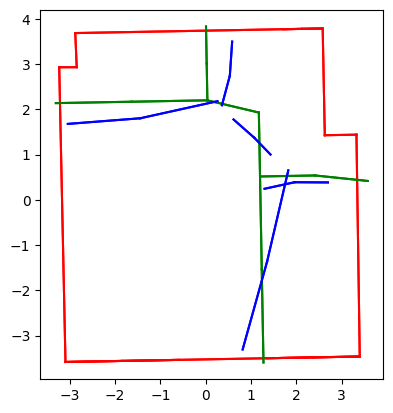

trainmodel 953


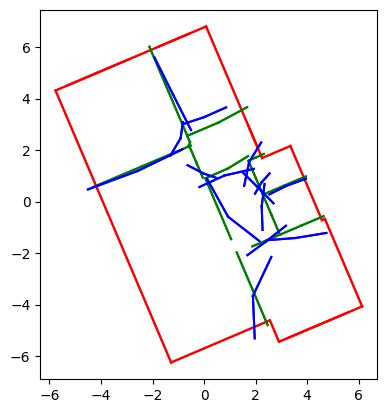

trainmodel 165


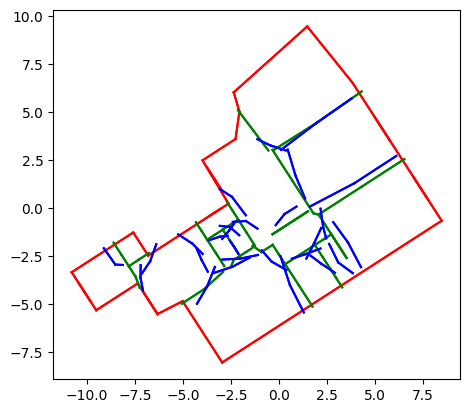

val 1129


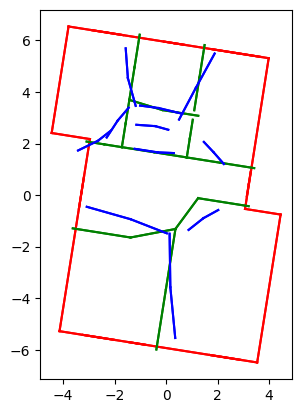

val 889


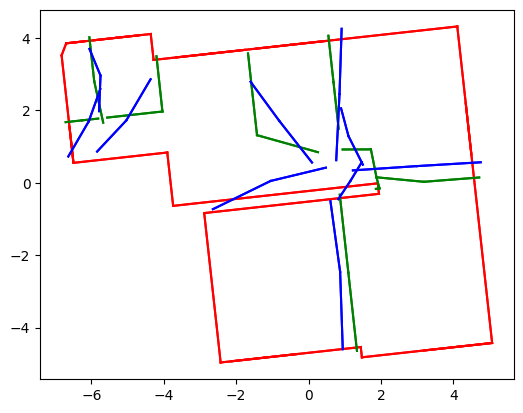

val 2519


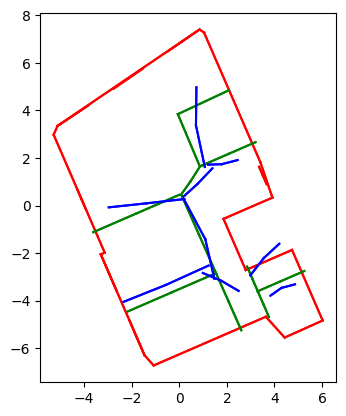

trainmodel loss


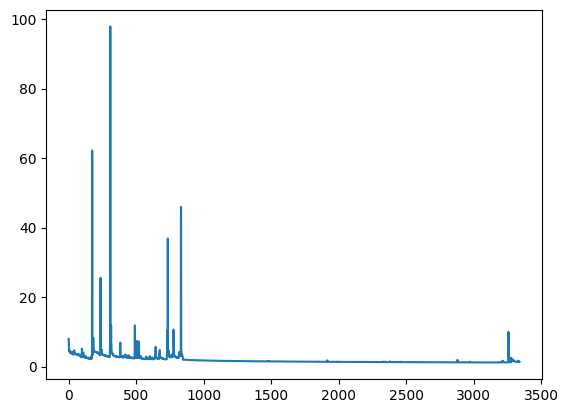

trainmodel loss_geom


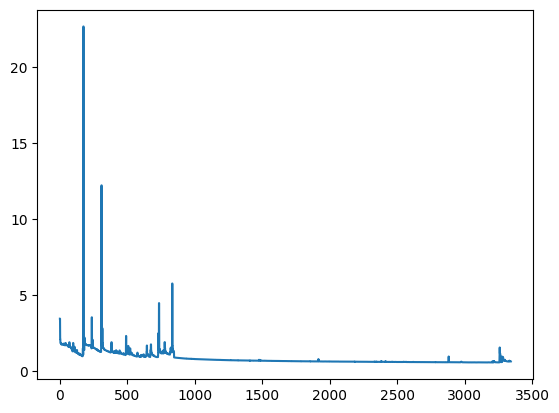

trainmodel loss_geom_length


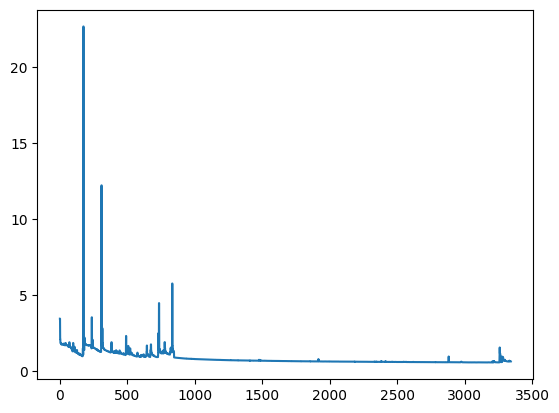

trainmodel loss_feat


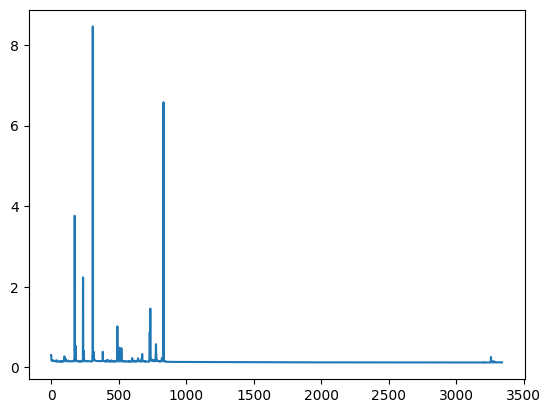

trainmodel loss_existence


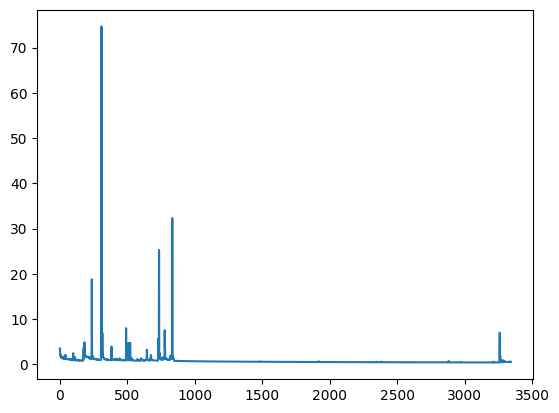

epoch
val loss


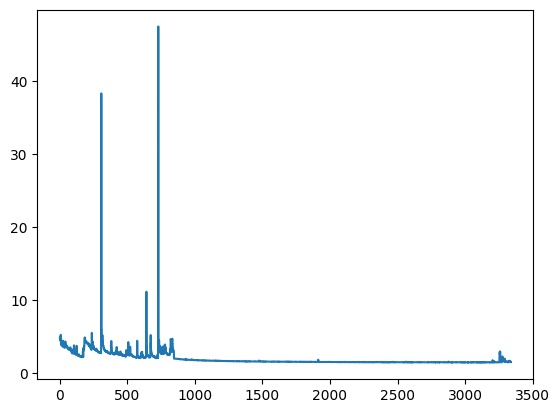

val loss_geom


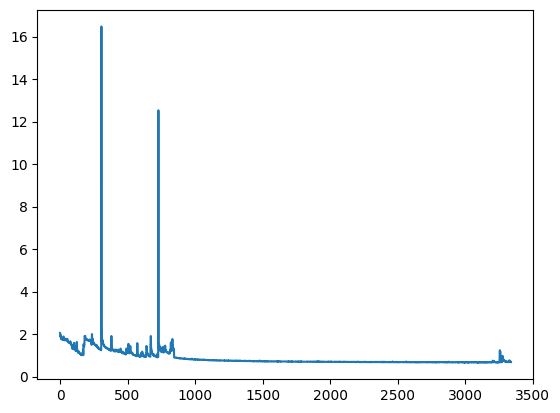

val loss_geom_length


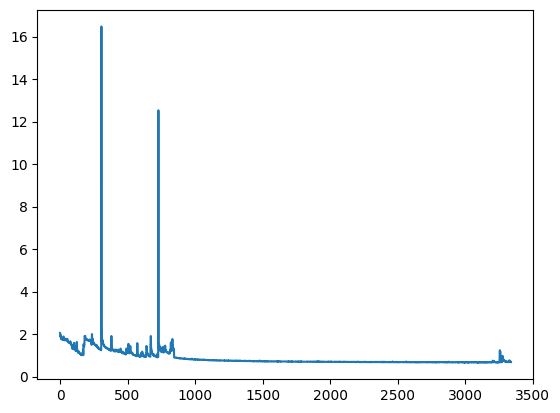

val loss_feat


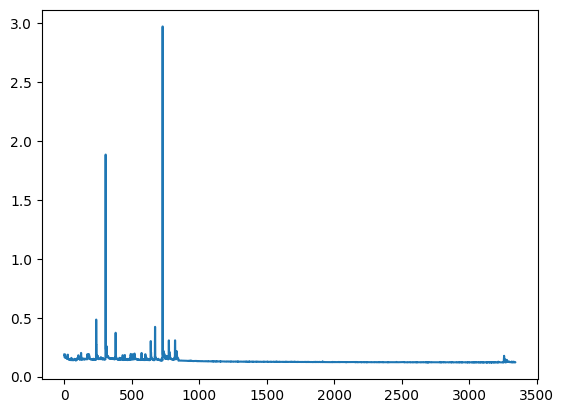

val loss_existence


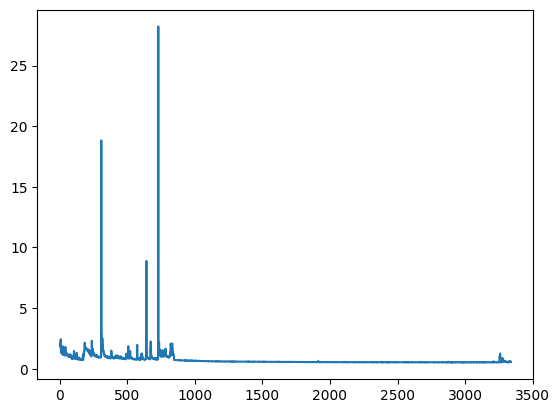

epoch_duration_minutes


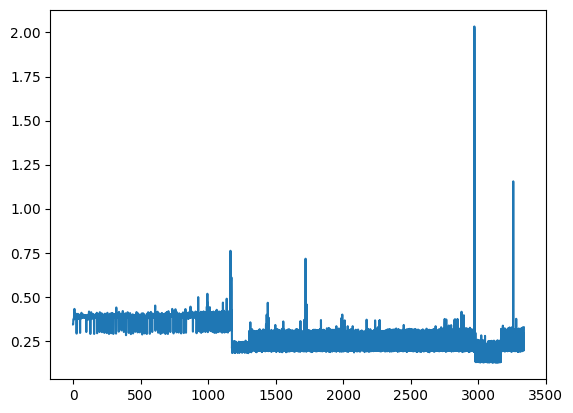

last_saved_at


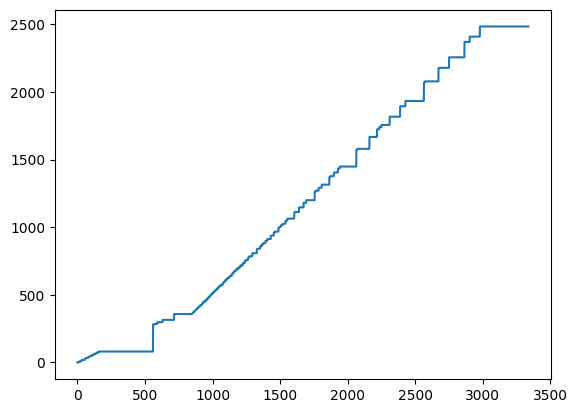

min_loss
val iter/total0/89
2561


/tmp/ipykernel_881273/133837734.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_881273/133837734.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_881273/133837734.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_881273/133837734.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_881273/133837734.py:9: UserWarning:

To c

KeyboardInterrupt: 

In [65]:


def filter_edges_by_inds(edges, inds):
    """
        Фильтрация ребер по списку индексов
         
    """
    msk = torch.isin(edges, inds).sum(0) > 0
    return edges[:, msk]


def train_val_epoch(model, loader, optimizer=None,
                    todo_train=False,
                    history_dict={},
                    current_dict={},
                    watch_indices=[],
                    drawings={},
                    epoch=0, prev_time=[0]):

    if todo_train:
        trvalstr = 'trainmodel'
        assert not optimizer is None
        with_cont = nullcontext
        model.train()
        current_dict['_epoch_start'] = time.time()
    else:
        trvalstr = 'val'
        with_cont = torch.no_grad
        model.eval()

    loss_avg = AverageMeter()
    loss_geom_avg = AverageMeter()
    loss_geom_length_avg = AverageMeter()
    loss_feat_avg = AverageMeter()
    loss_existence_avg = AverageMeter()

    for batch_index, batch in enumerate(loader):
        with with_cont():

            pred = model(batch.to(CUDA_0))

            feats_targ = batch.feats_targ
            targ_mask = feats_targ[:, 5] > 0.5
            pred_masked = pred[targ_mask]
            targ_masked = feats_targ[targ_mask]
            loss_existence = (
                pred_masked[:, 4:5] - targ_masked[:, 4:5]).pow(2).sum(1).mean(0) * 10.0

            targ_existed = targ_masked[:, 4] > 0.5
            pred_masked_existed = pred_masked[targ_existed]
            targ_masked_existed = targ_masked[targ_existed]
            loss_geom = (
                pred_masked_existed[:, :2] - targ_masked_existed[:, :2]).pow(2).sum(1).pow(1).mean(0)
            loss_feat = (
                pred_masked_existed[:, 2:4] - targ_masked_existed[:, 2:4]).pow(2).sum(1).mean(0)

            btw_targ_node_start_indices = batch.edge_index_debug_btw_targ_node_edge[0]
            btw_targ_node_end_indices = batch.edge_index_debug_btw_targ_node_edge[1]

            btw_targ_node_targ_start_pos = torch.gather(
                batch.feats_targ[:, :2], 0, btw_targ_node_start_indices[:, None].repeat((1, 2)))
            btw_targ_node_targ_end_pos = torch.gather(
                batch.feats_targ[:, :2], 0, btw_targ_node_end_indices[:, None].repeat((1, 2)))

            btw_targ_node_targ_vects = btw_targ_node_targ_end_pos - btw_targ_node_targ_start_pos
            btw_targ_node_targ_lengthes = btw_targ_node_targ_vects.pow(
                2).sum(1).pow(0.5)

            btw_targ_node_pred_start_pos = torch.gather(
                pred[:, :2], 0, btw_targ_node_start_indices[:, None].repeat((1, 2)))
            btw_targ_node_pred_end_pos = torch.gather(
                pred[:, :2], 0, btw_targ_node_end_indices[:, None].repeat((1, 2)))

            btw_targ_node_pred_vects = btw_targ_node_pred_end_pos - btw_targ_node_pred_start_pos
            btw_targ_node_pred_lengthes = btw_targ_node_pred_vects.pow(
                2).sum(1).pow(0.5)

            loss_geom_length = (btw_targ_node_pred_lengthes -
                                btw_targ_node_targ_lengthes).pow(2).mean()

            loss = loss_geom + loss_geom_length + loss_feat + loss_existence
            for i in watch_indices:
                watch_ind = i
                if not todo_train:
                    watch_ind = i - len(train_data)

                sample_msk = batch.debug_sg_ind == watch_ind
                if sample_msk.sum() > 0:
                    pred_sample = pred[sample_msk]

                    graph_nodes = batch.edge_index_debug_all_node_indices[sample_msk]

                    visible_pred_nodes_mask = pred_sample[:, 4] > 0.5
                    visible_pred_nodes = graph_nodes[visible_pred_nodes_mask]

                    edge_index_line = filter_edges_by_inds(
                        batch.edge_index_line, graph_nodes)
                    edge_index_debug_btw_targ_node_edge = filter_edges_by_inds(
                        batch.edge_index_debug_btw_targ_node_edge, graph_nodes)

                    edge_index_btw_pred_node_edge = filter_edges_by_inds(
                        batch.edge_index_debug_btw_targ_node_edge, visible_pred_nodes)

                    batch_pos_rotated = torch.matmul(
                        batch.pos[:, None, :], batch.debug_rev_rot_matr)[:, 0, :]
                    targ_rotated = torch.matmul(
                        feats_targ[:, :2][:, None, :], batch.debug_rev_rot_matr)[:, 0, :]
                    pred_rotated = torch.matmul(
                        pred[:, :2][:, None, :], batch.debug_rev_rot_matr)[:, 0, :]
                    lines = edges_to_plt_lines(
                        edge_index_line, batch_pos_rotated, targ_rotated)
                    btw_targ_node_edges = edges_to_plt_lines(
                        edge_index_debug_btw_targ_node_edge, batch_pos_rotated, targ_rotated)
                    btw_pred_node_edges = edges_to_plt_lines(
                        edge_index_btw_pred_node_edge, batch_pos_rotated, pred_rotated)

                    drawings[trvalstr + " " + str(watch_ind)] = {'lines': lines,
                                                                 'btw_targ_node_edges': btw_targ_node_edges,
                                                                 'btw_pred_node_edges': btw_pred_node_edges,
                                                                 }

            if todo_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            loss = loss.cpu().detach()
            loss_geom = loss_geom.cpu().detach()
            loss_feat = loss_feat.cpu().detach()
            loss_existence = loss_existence.cpu().detach()
            loss_geom_length = loss_geom_length.cpu().detach()
            pred_masked = pred_masked.cpu().detach()
            loss_geom_avg.update(loss_geom)
            loss_geom_length_avg.update(loss_geom_length)
            loss_feat_avg.update(loss_feat)
            loss_existence_avg.update(loss_existence)

            loss_avg.update(loss)

            current_dict[trvalstr + ' loss'] = loss_avg.avg
            current_dict[trvalstr + ' loss_geom'] = loss_geom_avg.avg
            current_dict[trvalstr + ' loss_geom_length'] = loss_geom_avg.avg
            current_dict[trvalstr + ' loss_feat'] = loss_feat_avg.avg
            current_dict[trvalstr + ' loss_existence'] = loss_existence_avg.avg
            current_dict['epoch'] = epoch
            # clear_output(wait=True)
            # for k,v in current_dict.items():
            #    print(k,v)
            # for k,v in drawings.items():
            #    print(k)

            if time.time() - prev_time[0] > 20:
                clear_output(wait=True)

                for k, v in current_dict.items():
                    if k[0] != "_":
                        print(k, v)
                for k, v in drawings.items():
                    print(k)
                    for type_, lines in v.items():
                        plt.plot(*lines, c=colors_dict[type_])
                    plt.gca().set_aspect("equal")
                    plt.show()

                for k, v in history_dict.items():
                    print(k)
                    if k != "epoch" and k != "min_loss":
                        plt.plot(v)
                        plt.show()
                prev_time[0] = time.time()

                print(trvalstr + ' iter/total' +
                      str(batch_index)+'/' + str(len(loader)))
    if not todo_train:

        if not current_dict.get('_epoch_start') is None:
            current_dict['epoch_duration_minutes'] = round(
                (time.time() - current_dict.get('_epoch_start'))/60.0, 3)

        for k, v in current_dict.items():
            if k[0] != "_":
                history_dict[k] = history_dict.get(k, [])
                history_dict[k].append(float(v))

            tensorboard_writer.add_scalar(k, float(v), epoch)


###########################
colors_dict = {'lines': 'r',
               'btw_targ_node_edges': 'g',
               'btw_pred_node_edges': 'b',
               'orientation': 'black'}


for e in range(100000):
    print(epoch)

    for train_step in range(2):

        if train_step == 0:
            todo_train = True
            loader = train_loader
        else:
            todo_train = False
            loader = val_loader

        train_val_epoch(model, loader, optimizer=optimizer,
                        todo_train=todo_train,
                        history_dict=history_dict,
                        current_dict=current_dict,
                        watch_indices=watch_indices,
                        drawings=drawings,
                        epoch=epoch, prev_time=prev_time)

    if current_dict.get('val' + ' loss', START_LOSS) < min_loss:
        save_weights(weights_pne,
                     model,
                     optimizer,
                     epoch,
                     min_loss)
        current_dict['last_saved_at'] = epoch
        min_loss = current_dict.get('val' + ' loss', START_LOSS)
        current_dict['min_loss'] = min_loss

    todo_stop_train = False
    if not current_dict.get('val' + ' loss', None):
        if current_dict['val' + ' loss'] < 0.5:
            todo_stop_train = True
            save_weights(weights_pne,
                         model,
                         optimizer,
                         epoch,
                         min_loss)

    if todo_stop_train:
        print('train done))')
        break

        # if not todo_train:
        # try:
        #    current_dict['lr'] = scheduler.get_last_lr()[-1]
        # except:
        #    current_dict['lr'] = -1
        # scheduler.step(float(current_dict['val' + ' loss']))

    epoch = epoch + 1

##### 